<a href="https://colab.research.google.com/github/amitmakashir/Deep-learning/blob/master/part1_Siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import math
import pandas
import pickle
import seaborn as sns
import itertools

sns.set(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

In [0]:
# These files are output of stft.load()

with open('hw4_trs.pkl', 'rb') as handle:
    trs = pickle.load(handle)
    
with open('hw4_tes.pkl', 'rb') as handle:
    tes = pickle.load(handle)

In [0]:
print(trs.shape)
print(tes.shape)

(500, 16180)
(200, 22631)


In [0]:
trs_stft = []
tes_stft = []

# STFT on training files
for i in range(trs.shape[0]):
    trs_op = librosa.stft(trs[i], n_fft=1024, hop_length=512)
    trs_stft.append(np.abs(trs_op.T))
    
# STFT on test files
for i in range(tes.shape[0]):
    tes_op = librosa.stft(tes[i], n_fft=1024, hop_length=512)
    tes_stft.append(np.abs(tes_op.T))

trs_stft = np.array(trs_stft)
tes_stft = np.array(tes_stft)

In [0]:
class miniBatch():
    '''
    Create mini Batches of the data for training the model
    In our case, we are making the default batch size as 90    
    
    '''
    def __init__(self,x,batch_size=90):
        self.x = x

        self.rows = len(x)
        self.batch_size = batch_size
        self.curr_index = 0

        # Total number of iterations
        # As every speaker has 10 clips we divide to the total clips by 10
        # to get the # of speakers
        self.iters = self.x.shape[0]//10
        pass


    def nextBatch(self):
        '''
        In each minibatch there are 2L pairs of utterances
        L => positive (both from same speaker)
        L => negative (different speaker)
        
        In our case, 2L = 90 (default)
        So we sample 45 pairs from first speaker as + examples
        And 45 pairs of first and other speaker as - examples
        Return the next batch of data        
        '''
        curr_index = self.curr_index
        
        # Generate a sequence of all the indices (len of training/test data)
        all_idxs = np.array([i for i in range(self.rows)]) 
        
        # Delete indices of the current speaker and call it other speaker
        other_idxs = np.delete(all_idxs,range(curr_index,curr_index+10))
        
        # Positive samples
        positive_comb = list(itertools.combinations(range(curr_index,curr_index+10),2))
        
        # positive_idxs.shape => (90,2) 
        positive_idxs = np.array([[i_tup[0],i_tup[1]] for i_tup in positive_comb])
        
        # Negative samples    
        # a and b are indices
        # a is sampled from the current speaker
        # b is sampled from the other speakers
        a_idxs = np.random.choice(range(curr_index,curr_index+10), self.batch_size//2, replace=True)  
        b_idxs = np.random.choice(other_idxs, self.batch_size//2, replace=False)
        
        # a_idxs.shape => (90,) 
        # After reshape => (90,1); this helps in concatenating by columns
        # Same goes for b
        a_idxs = np.reshape(a_idxs,(self.batch_size//2,1))
        b_idxs = np.reshape(b_idxs,(self.batch_size//2,1))

        negative_idxs = np.concatenate((a_idxs,b_idxs),axis=1) # negative.shape => (2,batchsize/2)
        
        # Combining + and - samples
        final_idxs = np.concatenate((positive_idxs,negative_idxs),axis=0)
        
        # Slice into two parts as every row has two elements
        # Pass each column into a network 
        left = final_idxs[:,0]
        right = final_idxs[:,1]
        
        self.curr_index = curr_index + 10 
        
        # The first half is positive examples and second half is negative
        # Create a y (label) array accordingly
        y_positive = np.ones(self.batch_size//2)
        y_negative = np.zeros(self.batch_size//2)
        y = np.concatenate((y_positive,y_negative),axis=0)
        
        return self.x[left],self.x[right], y 
        

## Training

In [0]:
learning_rate = 0.003 
epochs = 120 

In [0]:
tf.reset_default_graph()

# Create placeholders for input X and labels y
x_left = tf.placeholder(tf.float32, [None,None,513])
x_right = tf.placeholder(tf.float32, [None,None,513])
y_true = tf.placeholder(tf.float32, [None])

# defining the network   
def model(x,reuse=False):
    hidden_units_1 = 256
    hidden_units_2 = 128
    hidden_units_3 = 128
    
    initializer = tf.contrib.layers.xavier_initializer()
    
    rnn_cell_1 = tf.contrib.rnn.GRUCell(num_units = hidden_units_1,
                                        kernel_initializer = initializer,
                                        name = "rnn1",
                                       reuse=reuse)

    rnn_dropout_1 = tf.contrib.rnn.DropoutWrapper(rnn_cell_1,
                                                 input_keep_prob=0.90, 
                                                 output_keep_prob=0.90)
    
    rnn_cell_2 = tf.contrib.rnn.GRUCell(num_units = hidden_units_2,
                                        kernel_initializer = initializer,
                                        name = "rnn2",
                                       reuse=reuse)

    rnn_dropout_2 = tf.contrib.rnn.DropoutWrapper(rnn_cell_2,
                                                 input_keep_prob=0.90, 
                                                 output_keep_prob=0.90)
    
    rnn_cell_3 = tf.contrib.rnn.GRUCell(num_units = hidden_units_3,
                                        kernel_initializer = initializer,
                                        name = "rnn3",
                                       reuse=reuse)

    rnn_dropout_3 = tf.contrib.rnn.DropoutWrapper(rnn_cell_3,
                                                 input_keep_prob=0.95, 
                                                 output_keep_prob=0.90)
    
    lstm_layers = tf.contrib.rnn.MultiRNNCell([rnn_dropout_1,rnn_dropout_2])
    

    network_output, state = tf.nn.dynamic_rnn(cell = lstm_layers,
                                              inputs = x,
                                              dtype="float32")
    
    # converting last output of dimension [batch_size,num_units] to [batch_size,n_classes] by out_weight multiplication
    y_slast = tf.layers.dense(inputs = network_output, 
                                 units = 10, 
                                 kernel_initializer = initializer,
                                 activation = tf.nn.leaky_relu,
                                 bias_initializer = tf.zeros_initializer(),
                              name="dense1",
                                reuse=reuse)
    
    dropout_layer = tf.layers.dropout(y_slast,
                      rate=0.1
                     )
    
    y_network_output = tf.layers.dense(inputs = y_slast, 
                                     units = 20, 
                                     kernel_initializer = initializer,
                                     activation = tf.nn.leaky_relu,
                                     bias_initializer = tf.zeros_initializer(),
                                    name="dense2",
                                    reuse=reuse)
    
    dropout_layer = tf.layers.dropout(y_network_output,
                      rate=0.1
                     )

#     The output will be of the shape: (batch,100)
    return tf.layers.flatten(y_network_output)



# Get a fixed length vector from the network
vec_left = model(x_left)
vec_right = model(x_right,reuse=True)


# vec_left and vec_right are 3d tensors with shape (batch,Timestamp,513)
# We want to reduce it to a tensor with shape (batch)
# We first take elementwise multiplication of the two tensors (left and right)
# We call reduce_sum with axis=1 (timestamp) so it collapse rows in that matrix
# After the inner product of these two vectors (for each data point) you'll have a scalar
# Apply sigmoid on it to get a label
vec_prod = tf.multiply(vec_left,vec_right) 

vec_sum = tf.reduce_sum(vec_prod, axis=1)

y_pred_sigmoid = tf.math.sigmoid(vec_sum)  # This will the output for feedforward
y_pred = vec_sum  # We will use this for further calculations (loss function)

# Contrastive loss_function
# loss_func = -(tf.multiply(y_true,tf.log(y_pred+ (10**-9))) + tf.multiply(1 - y_true,tf.log(1 - y_pred + (10**-9))))
loss_func = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred)
loss = tf.reduce_mean(loss_func)

# optimization
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

### Start the session
sess = tf.InteractiveSession()
# train_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)
tf.global_variables_initializer().run()


# Create a mini-batch from the test audio files
# Test the network on this batch after every epoch
# Record this loss
test_mini_batch = miniBatch(tes_stft)
test_left,test_right,test_y = test_mini_batch.nextBatch()

test_loss = []
train_loss = []

# ============  Training the network ============ #  
for e in range(epochs):
    # Create minibatches and train data on it
    mini_batch = miniBatch(trs_stft)
    
    for iter in range(mini_batch.iters):
        left,right,y = mini_batch.nextBatch()
        _,trs_loss = sess.run([train_step,loss], feed_dict={x_left:left,x_right:right, y_true: y})
        train_loss.append(trs_loss)
    test_loss.append(sess.run(loss, feed_dict={x_left:test_left,x_right:test_right, y_true: test_y}))

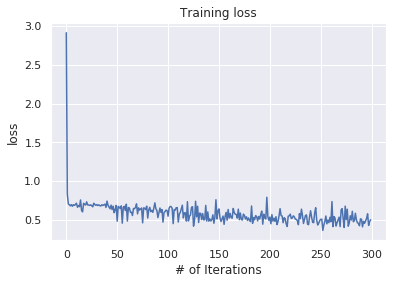

Final training loss:  0.61878216


In [0]:
# Plotting the train loss
sns.set_style("darkgrid")
plt.plot(train_loss[::20])
plt.xlabel("# of Iterations")
plt.ylabel("loss")
plt.title("Training loss")
plt.show()
print("Final training loss: ",str(train_loss[-1]))

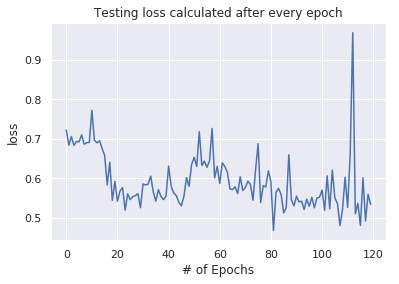

Final testing loss:  0.53421694


In [0]:
# Plotting the test loss
sns.set_style("darkgrid")
plt.plot(test_loss)
plt.xlabel("# of Epochs")
plt.ylabel("loss")
plt.title("Testing loss calculated after every epoch")
plt.show()
print("Final testing loss: ",str(test_loss[-1]))

## Testing

To test our model, we will create minibatches like we did for the training examples. 

For eg: 
Say the first 10 audio files are for speaker 1. We take all combinations of this speaker's audio files and call it *positive* examples. We can take 1 file from this speaker and 1 from some other speaker and call it *negative* examples. Like in training, for every speaker, we'll be generating 90 pairs (45 +ve and 45 -ve).

We won't pass the labels and calculate the accuracy for every batch. The mean accuracy across all batches would tell us the performance of our model. 


In [0]:
# Testing
mini_batch = miniBatch(tes_stft)
test_accuracy = []

for iter in range(mini_batch.iters):
    left,right,y_true = mini_batch.nextBatch()
    y_test_pred = sess.run(y_pred_sigmoid, feed_dict={x_left:left,x_right:right})
    
    # The values of y_pred needs to be thresholded
    threshold = 0.5
    y_test_pred[y_test_pred >= threshold] = 1
    y_test_pred[y_test_pred < threshold] = 0
    
    acc = (np.sum(y_test_pred == y_true))/y_test_pred.shape[0]

    test_accuracy.append(acc)

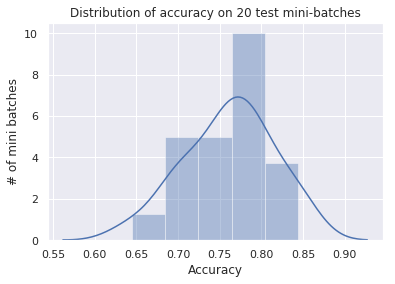

In [0]:
sns.distplot(test_accuracy)
plt.title("Distribution of accuracy on 20 test mini-batches")
plt.xlabel("Accuracy")
plt.ylabel("# of mini batches")
plt.show()

In [0]:
mean_acc = round(np.mean(test_accuracy),3)
print("The mean accuracy on test examples is :",mean_acc)

The mean accuracy on test examples is : 0.761
